# Pruebas de Separación 

In [1]:
#imports
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import numpy as np
from sklearn.decomposition import FastICA
from aux_func import *
from sklearn.decomposition import PCA

In [2]:
#Importar base de datos
mat=load_mat("C:/Users/34648/Desktop/Clases/4_GITT/TFG/OPENICPSR/TR2_postTMR_32chanEMG.mat") #Esto direccion absoluta cuidado


## Pruebas con 2 caneles con mano abierta

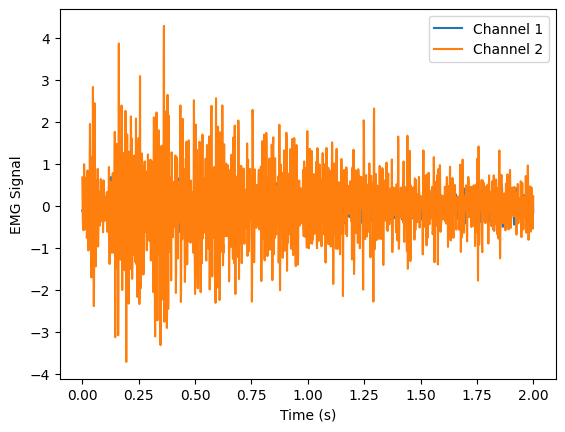

In [3]:
emg=find_movement_rep(mat,"handOpen",rep=1)[0]
ch1=emg[:,0]
ch2=emg[:,20]
fs=1000
ts=1/fs
t=np.arange(0, len(ch1)*ts, ts)
plt.plot(t, ch1, label='Channel 1')
plt.plot(t, ch2, label='Channel 2')
plt.xlabel('Time (s)')
plt.ylabel('EMG Signal')
plt.legend()

## Preprocesado sin filtros
1. Quitar dc
2. Eliminar outliers
3. Escalar los canales

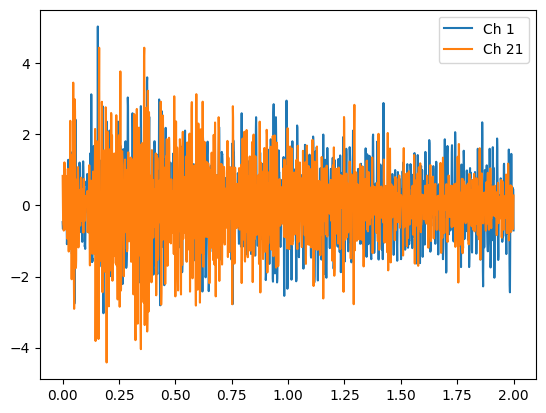

In [4]:
emg = find_movement_rep(mat, "handOpen", rep=1)[0]


emg = eliminar_continua(emg)
emg = eliminar_outiliers(emg, k=8)
emg = escalar_canales(emg, metodo="rms")  # o zscore

ch1 = emg[:, 0]
ch2 = emg[:, 20]

t = np.arange(0, len(ch1) / fs, 1 / fs)

plt.plot(t, ch1, label="Ch 1")
plt.plot(t, ch2, label="Ch 21")  # recuerda: index 20 = canal 21
plt.legend()



# 1. Separación a Ciegas segun independencia estadísitca
## ICA (Independent Component Analysis)

Los primeros algoritmo que se estudiarán son los ICA

## Pruebas de c1 y c2
### Caso 1: dos fuentes con atenuacion bidireccional $\beta$
Empezando con el caso más trivial, la primera prueba es probar a separar 2 señales de canales mas o menos independientes segun las siguientes combinaciones:
- $c_1=s_1 +\beta*s_2$
- $c_2=\beta*s_1 +s_2$

Se busca:
- Comprobar que similaridad entre las componentes independientes (ICs) y la señales originales
- Analizar la matriz de separación
- Observar como varia la separacion segun los valores de $\beta$

In [5]:
from sklearn.discriminant_analysis import StandardScaler


s1 = emg[:, 18]
s2 = emg[:, 27]
S_original = np.c_[s1, s2]
def test_fastica_beta(s1, s2, beta):
    #1 Crear mezcla
    c1 = s1 + beta * s2
    c2 = s2 + beta * s1
    X = np.c_[c1, c2]
    
    #2 Aplicar FastICA
    ica = FastICA(n_components=2, random_state=42, whiten='unit-variance')
    S_derived = ica.fit_transform(X)  # Señales estimadas (ICs)
    W = ica.components_               # Matriz de separación estimada
    
    return X, S_derived, W

#Escoger beta
for beta_test in [0.1, 0.5, 0.8]:
    X, S_derived, W = test_fastica_beta(s1, s2, beta_test)
    S_aligned, C_final = match_and_fix(S_original.T, S_derived.T)
    print(f"ICA finalizado para beta = {beta_test}")

    print("Matriz de correlación final C:\n", C_final)

ICA finalizado para beta = 0.1
Matriz de correlación final C:
 [[ 0.97448275 -0.2244624 ]
 [-0.00126667  0.9999992 ]]
ICA finalizado para beta = 0.5
Matriz de correlación final C:
 [[ 0.97686925 -0.21383747]
 [-0.01215608  0.99992611]]
ICA finalizado para beta = 0.8
Matriz de correlación final C:
 [[ 0.97686925 -0.21383749]
 [-0.01215606  0.99992611]]


In [6]:
def analizar_similaridad(S_orig, S_est):
    n_src = S_orig.shape[1]
    correlaciones = np.zeros((n_src, n_src))
    
    for i in range(n_src):
        for j in range(n_src):
            matriz_corr = np.corrcoef(S_orig[:, i], S_est[:, j])
            corr_valor = matriz_corr[0, 1]
            
            #ICA invierte fases sin saber-> Tomar valor absoluto!!!!!!!!!!!!!!!
            correlaciones[i, j] = abs(corr_valor)
            
    return correlaciones

# Ejecutamos el análisis
corrs = analizar_similaridad(S_original, S_derived)

print("Matriz de Correlación (Filas: Fuentes Originales, Columnas: ICs recuperadas):")
print(np.round(corrs, 4))

# Identificar qué IC corresponde a qué fuente
for i in range(corrs.shape[0]):
    best_match = np.argmax(corrs[i, :])
    print(f"La Señal Original {i+1} coincide mejor con la IC {best_match+1} (Corr: {corrs[i, best_match]:.4f})")

Matriz de Correlación (Filas: Fuentes Originales, Columnas: ICs recuperadas):
[[0.2138 0.9769]
 [0.9999 0.0122]]
La Señal Original 1 coincide mejor con la IC 2 (Corr: 0.9769)
La Señal Original 2 coincide mejor con la IC 1 (Corr: 0.9999)


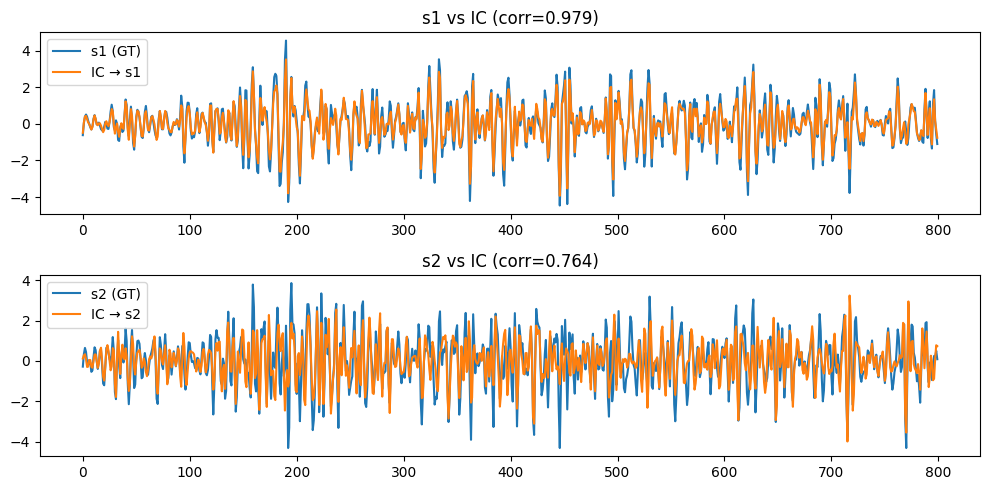

In [13]:
from scipy.optimize import linear_sum_assignment


def match_and_fix(S_true, S_est):
    C = corr_matrix(S_true, S_est)
    cost = 1 - np.abs(C)
    rows, cols = linear_sum_assignment(cost)

    S_al = S_est[cols, :].copy()
    matched_corr = C[rows, cols]
    signs = np.sign(matched_corr)
    signs[signs == 0] = 1
    S_al *= signs[:, None]

    C_final = corr_matrix(S_true, S_al)
    return S_al, C_final

# -----------------------------
# 1) Fuentes reales (ground truth)
# -----------------------------
emg = find_movement_rep(mat, "handOpen", rep=1)[0]
emg = eliminar_continua(emg)
emg = eliminar_outiliers(emg, k=8)
emg = escalar_canales(emg, metodo="rms")

s1 = emg[:, 25]
s2 = emg[:, 27]
S = np.vstack([s1, s2])

# limitar longitud para claridad
N = 800
S = S[:, :N]

#Matriz de mezcla
A = np.array([[1, 0.7],
              [0.7, 1]])

X = A @ S


ica = FastICA(
    n_components=2,
    whiten="unit-variance",
    random_state=0,
    max_iter=2000,   # pocas iteraciones
    tol=1e-12
)
S_hat = ica.fit_transform(X.T).T
S_aligned, C_final = match_and_fix(S, S_hat)

t = np.arange(N)

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t, S[0], label="s1 (GT)")
plt.plot(t, S_aligned[0], label="IC → s1")
plt.title(f"s1 vs IC (corr={C_final[0,0]:.3f})")
plt.legend()

plt.subplot(2,1,2)
plt.plot(t, S[1], label="s2 (GT)")
plt.plot(t, S_aligned[1], label="IC → s2")
plt.title(f"s2 vs IC (corr={C_final[1,1]:.3f})")
plt.legend()

plt.tight_layout()
plt.show()


## Entonces, a que afecta Beta?

In [8]:
def amari_error(W, A):
    """
    Amari error entre la matriz de separación W y la de mezcla A.
    Invariante a escala, signo y permutación.
    """
    P = W @ A
    P = np.abs(P)

    n = P.shape[0]

    row = np.sum(P, axis=1) - np.max(P, axis=1)
    col = np.sum(P, axis=0) - np.max(P, axis=0)

    return (row.sum() + col.sum()) / (2 * n)


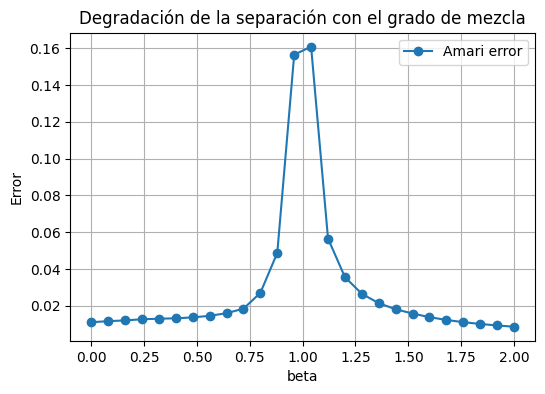

In [9]:
betas = np.linspace(0.0, 2, 26)
amari_vals = []
cond_vals = []

for beta in betas:
    A = np.array([[1.0, beta],
                  [beta, 1.0]])
    X = A @ S

    ica = FastICA(
        n_components=2,
        whiten="unit-variance",
        random_state=0,
        max_iter=2000,
        tol=1e-5
    )
    S_ = ica.fit_transform(X.T).T
    W = ica.components_  @ ica.whitening_


    amari_vals.append(amari_error(W, A))
    cond_vals.append(np.linalg.cond(A))

plt.figure(figsize=(6, 4))
plt.plot(betas, amari_vals, "o-", label="Amari error")
plt.xlabel("beta")
plt.ylabel("Error")
plt.grid(True)
plt.legend()
plt.title("Degradación de la separación con el grado de mezcla")
plt.show()


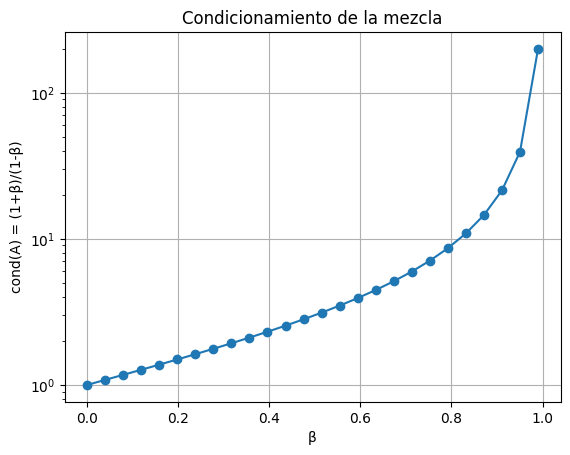

In [20]:
betas = np.linspace(0.0, 0.99, 26)
kappa = [(1+b)/(1-b) for b in betas]
plt.semilogy(betas, kappa, marker="o")
plt.xlabel("β")
plt.ylabel("cond(A) = (1+β)/(1-β)")
plt.title("Condicionamiento de la mezcla")
plt.grid(True)
plt.show()

Matriz de correlación fuente ↔ IC (sin matching):
[[-0.77601367 -0.63071609]
 [-0.92607273  0.37734506]]

Asignación (fuente -> IC): {'s1': 'IC2', 's2': 'IC1'}
Signos aplicados: [-1. -1.]

Matriz de correlación fuente ↔ IC (con matching + signo):
[[ 0.63071609  0.77601367]
 [-0.37734506  0.92607273]]


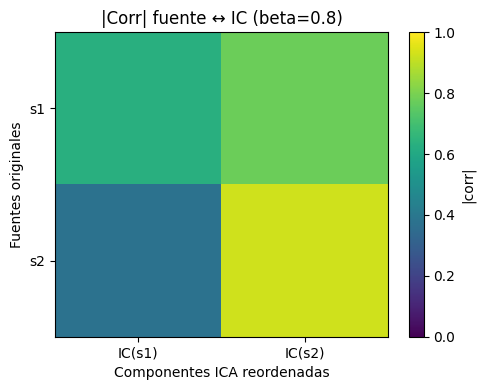

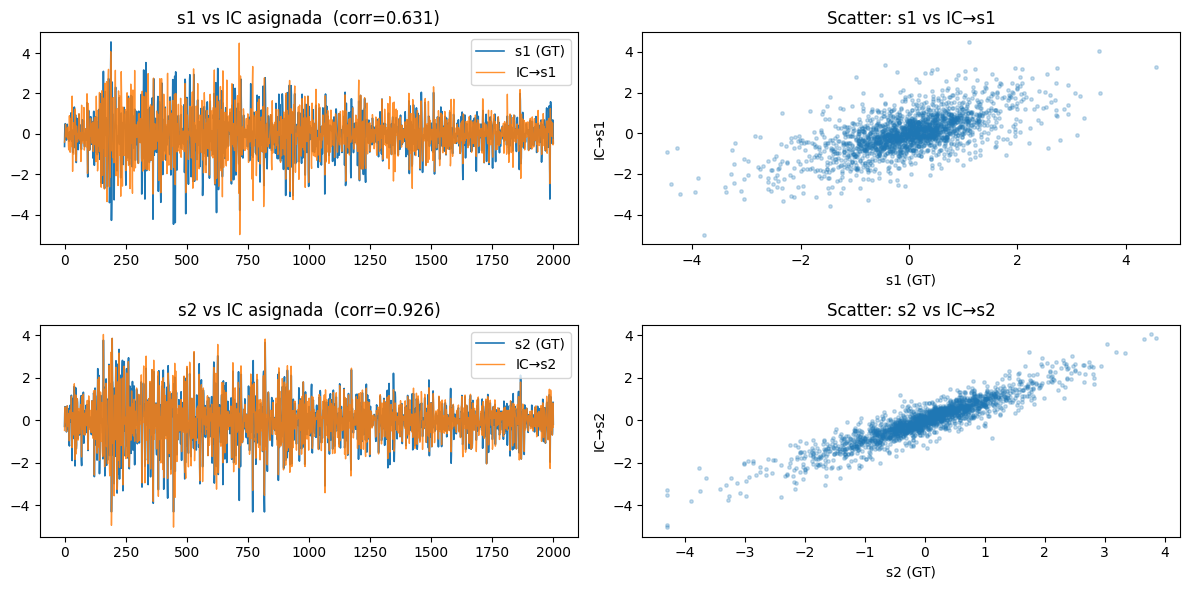


W (ICA components_):
 [[ 0.40301864 -1.04166169]
 [-4.90003132  4.80496417]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

# -----------------------------
# Cargar + preprocesar
# -----------------------------
emg = find_movement_rep(mat, "handOpen", rep=1)[0]

emg = eliminar_continua(emg)
emg = eliminar_outiliers(emg, k=8)
emg = escalar_canales(emg, metodo="rms")  # o "zscore"

s1 = emg[:, 25]
s2 = emg[:, 27]

S = np.vstack([s1, s2])  # (2, N)

# -----------------------------
# Mezcla (ground truth)
# -----------------------------
beta = 0.8
A = np.array([[1.0, beta],
              [beta, 1.0]])

X = A @ S  # (2, N)

# -----------------------------
# ICA
# -----------------------------
ica = FastICA(
    n_components=2,
    whiten="unit-variance",
    random_state=0,
    max_iter=2000,
    tol=1e-5
)

S_hat = ica.fit_transform(X.T).T   # (2, N)  -> ICs
W = ica.components_                # (2, 2)

# -----------------------------
# Correlación + matching (Hungarian) + corrección de signo
# -----------------------------
C = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        C[i, j] = np.corrcoef(S[i], S_hat[j])[0, 1]

# Hungarian sobre |corr|
cost = 1.0 - np.abs(C)
rows, cols = linear_sum_assignment(cost)  # rows=[0,1], cols = IC asignada a cada fuente

# Reordenar ICs para que coincidan con s1,s2
S_hat_ord = S_hat[cols, :].copy()  # (2, N) en el orden de las fuentes

matched_corr = C[rows, cols]          # (2,)  correlaciones emparejadas (con signo)
signs = np.sign(matched_corr)         # (2,)
signs[signs == 0] = 1.0
S_hat_ord = S_hat_ord * signs[:, None]  # (2,N) OK

#Correlacion
C_final = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        C_final[i, j] = np.corrcoef(S[i], S_hat_ord[j])[0, 1]

print("Matriz de correlación fuente ↔ IC (sin matching):")
print(C)
print("\nAsignación (fuente -> IC):", {f"s{i+1}": f"IC{cols[i]+1}" for i in range(2)})
print("Signos aplicados:", signs)
print("\nMatriz de correlación fuente ↔ IC (con matching + signo):")
print(C_final)

# -----------------------------
# Heatmap |corr|
# -----------------------------
plt.figure(figsize=(5, 4))
plt.imshow(np.abs(C_final), vmin=0, vmax=1, aspect="auto")
plt.colorbar(label="|corr|")
plt.xticks([0, 1], ["IC(s1)", "IC(s2)"])
plt.yticks([0, 1], ["s1", "s2"])
plt.xlabel("Componentes ICA reordenadas")
plt.ylabel("Fuentes originales")
plt.title(f"|Corr| fuente ↔ IC (beta={beta})")
plt.tight_layout()
plt.show()

# -----------------------------
# Representación IC vs ground truth (overlay + scatter)
# -----------------------------
N = S.shape[1]
t = np.arange(N)  # si quieres tiempo real: t = np.arange(N)/fs

fig = plt.figure(figsize=(12, 6))

# s1 vs IC asignada a s1
ax1 = plt.subplot(2, 2, 1)
ax1.plot(t, S[0], label="s1 (GT)", linewidth=1.2)
ax1.plot(t, S_hat_ord[0], label="IC→s1", linewidth=1.0, alpha=0.85)
ax1.set_title(f"s1 vs IC asignada  (corr={np.corrcoef(S[0], S_hat_ord[0])[0,1]:.3f})")
ax1.legend(loc="upper right")

ax2 = plt.subplot(2, 2, 2)
ax2.scatter(S[0], S_hat_ord[0], s=6, alpha=0.25)
ax2.set_xlabel("s1 (GT)")
ax2.set_ylabel("IC→s1")
ax2.set_title("Scatter: s1 vs IC→s1")

# s2 vs IC asignada a s2
ax3 = plt.subplot(2, 2, 3)
ax3.plot(t, S[1], label="s2 (GT)", linewidth=1.2)
ax3.plot(t, S_hat_ord[1], label="IC→s2", linewidth=1.0, alpha=0.85)
ax3.set_title(f"s2 vs IC asignada  (corr={np.corrcoef(S[1], S_hat_ord[1])[0,1]:.3f})")
ax3.legend(loc="upper right")

ax4 = plt.subplot(2, 2, 4)
ax4.scatter(S[1], S_hat_ord[1], s=6, alpha=0.25)
ax4.set_xlabel("s2 (GT)")
ax4.set_ylabel("IC→s2")
ax4.set_title("Scatter: s2 vs IC→s2")

plt.tight_layout()
plt.show()



### Caso 1.b. Dos fuentes con atenuacion bidireccional $\beta$ y ruido

\begin{aligned}
c_1 &= s_1 + \beta\, s_2 + n_1 \\
c_2 &= s_2 + \beta\, s_1 + n_2 \\
n_1, n_2 & \;\text{independientes} \;\sim\; \mathcal{N}(0,\texttt{noise\_level}^2)
\end{aligned}

NOTA: se considera ruido blanco y gausiano




In [26]:
import numpy as np
from sklearn.decomposition import FastICA

def test_fastica_con_ruido(s1, s2, beta, noise_level=0.0, random_state=0,
                           max_iter=2000, tol=1e-12):
    """
    Mezcla 2 fuentes con A=[[1,b],[b,1]] y añade ruido gaussiano N(0, noise_level^2) a los canales observados.
    Devuelve S_est con shape (N,2) para que encaje con tu código.
    """
    s1 = np.asarray(s1, dtype=float).ravel()
    s2 = np.asarray(s2, dtype=float).ravel()
    N = min(len(s1), len(s2))
    s1 = s1[:N]
    s2 = s2[:N]

    # Fuentes (2,N)
    S = np.vstack([s1, s2])

    # Mezcla (2,N)
    A = np.array([[1.0, beta],
                  [beta, 1.0]], dtype=float)
    X = A @ S

    # Ruido aditivo en los canales observados
    if noise_level and noise_level > 0:
        X = X + np.random.normal(0.0, noise_level, size=X.shape)

    # ICA (espera (N, n_features))
    ica = FastICA(n_components=2, whiten="unit-variance",
                  random_state=random_state, max_iter=max_iter, tol=tol)

    S_est = ica.fit_transform(X.T)  # (N,2)
    return S_est


def calcular_max_corr(S_original, S_est):
    """
    Calcula la similaridad media (Pearson) entre S_original (N,2) y S_est (N,2)
    probando las dos asignaciones posibles e ignorando signo (abs(corr)).
    Devuelve un escalar en [0,1].
    """
    S_original = np.asarray(S_original, dtype=float)
    S_est = np.asarray(S_est, dtype=float)

    # corr(i,j) = corr( fuente i, componente j )
    def pearson(x, y):
        # robusto a medias/escala
        x = x - x.mean()
        y = y - y.mean()
        denom = (np.sqrt(np.sum(x*x)) * np.sqrt(np.sum(y*y)) + 1e-12)
        return float(np.sum(x*y) / denom)

    c00 = abs(pearson(S_original[:, 0], S_est[:, 0]))
    c01 = abs(pearson(S_original[:, 0], S_est[:, 1]))
    c10 = abs(pearson(S_original[:, 1], S_est[:, 0]))
    c11 = abs(pearson(S_original[:, 1], S_est[:, 1]))

    # Dos asignaciones posibles (2x2): (0->0,1->1) o (0->1,1->0)
    score_id = 0.5 * (c00 + c11)
    score_sw = 0.5 * (c01 + c10)

    return max(score_id, score_sw)


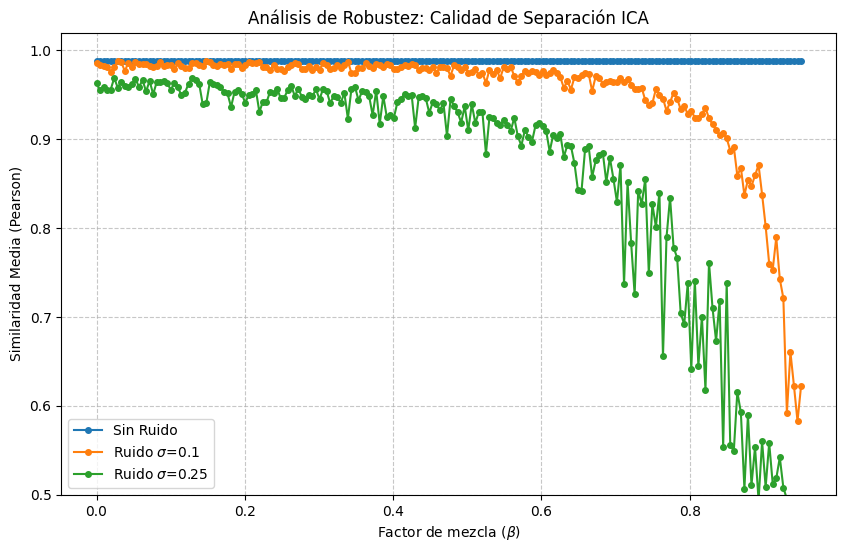

In [28]:
import matplotlib.pyplot as plt
s1 = emg[:, 6]
s2 = emg[:, 27]
S_original = np.c_[s1, s2]
#Evitar beta=1.0 (esto da in condicionamiento infinito!!!!!!!!!!!!!!!!!!!!!!!!)
betas = np.linspace(0, 0.95, 200)
niveles_ruido = [0.0, 0.1, 0.25,] 
colores = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.figure(figsize=(10, 6))

for noise, color in zip(niveles_ruido, colores):
    mejor_corr_por_beta = []
    
    for b in betas:
        S_est = test_fastica_con_ruido(s1, s2, b, noise_level=noise)
        mejor_corr_por_beta.append(calcular_max_corr(S_original, S_est))
    
    label = "Sin Ruido" if noise == 0 else f"Ruido $\sigma$={noise}"
    plt.plot(betas, mejor_corr_por_beta, 'o-', label=label, color=color, markersize=4)

plt.title("Análisis de Robustez: Calidad de Separación ICA")
plt.xlabel("Factor de mezcla ($\\beta$)")
plt.ylabel("Similaridad Media (Pearson)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.ylim(0.5, 1.02) 
plt.show()

In [ ]:
import numpy as np
from itertools import combinations

def canales_menor_correlacion(emg):
    """
    emg: array (n_samples, n_channels)
    Devuelve:
      (i, j): índices de los canales
      corr: correlación entre ellos
    """
    n_channels = emg.shape[1]

    min_corr = np.inf
    best_pair = None

    for i, j in combinations(range(n_channels), 2):
        c = np.corrcoef(emg[:, i], emg[:, j])[0, 1]
        if np.abs(c) < min_corr:
            min_corr = np.abs(c)
            best_pair = (i, j)
            best_corr = c

    return best_pair, best_corr
(pair, corr) = canales_menor_correlacion(emg)
print(f"Canales con menor correlación: {pair}")
print(f"Correlación: {corr:.4f}")


Canales con menor correlación: (6, 27)
Correlación: -0.0010


## Caso 2: Atenuaciones unilaterales

En este caso se considera que a cada electrodo le llega cada señal con atenuaciones diferentes.

\begin{aligned}
c_1 &= a_{11} s_1 + a_{12} s_2 \\
c_2 &= a_{21} s_1 + a_{22} s_2 \\
\end{aligned}



C:\Users\34648\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


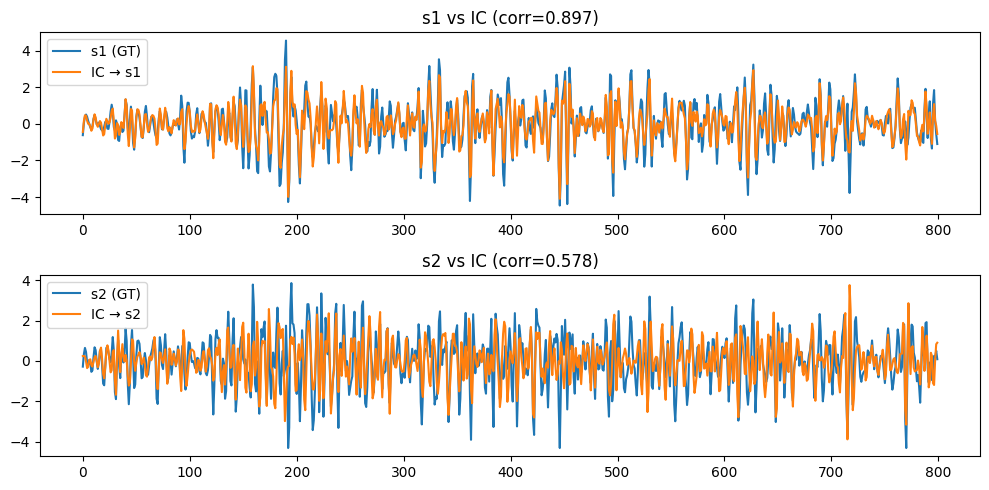

In [51]:
from scipy.optimize import linear_sum_assignment

# -----------------------------
# 1) Fuentes reales (ground truth)
# -----------------------------
emg = find_movement_rep(mat, "handOpen", rep=1)[0]
emg = eliminar_continua(emg)
emg = eliminar_outiliers(emg, k=8)
emg = escalar_canales(emg, metodo="rms")

s1 = emg[:, 25]
s2 = emg[:, 27]
S = np.vstack([s1, s2])

# limitar longitud para claridad
N = 800
S = S[:, :N]

#Matriz de mezcla
A = np.array([[0.2, 0.9],
              [0.5, 0.6]])

X = A @ S


ica = FastICA(
    n_components=2,
    whiten="unit-variance",
    random_state=0,
    max_iter=2,   # pocas iteraciones
    tol=1e-12
)
S_hat = ica.fit_transform(X.T).T
S_aligned, C_final = match_and_fix(S, S_hat)

t = np.arange(N)

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t, S[0], label="s1 (GT)")
plt.plot(t, S_aligned[0], label="IC → s1")
plt.title(f"s1 vs IC (corr={C_final[0,0]:.3f})")
plt.legend()

plt.subplot(2,1,2)
plt.plot(t, S[1], label="s2 (GT)")
plt.plot(t, S_aligned[1], label="IC → s2")
plt.title(f"s2 vs IC (corr={C_final[1,1]:.3f})")
plt.legend()

plt.tight_layout()
plt.show()


## Caso 3: Retardos temporales entre fuentes

$$
\begin{cases}
c_1(t) = s_1(t) + \beta\, s_2(t-\tau) \\
c_2(t) =  \beta\, s_1(t-\tau) +s_2(t) 
\end{cases}
$$

In [40]:
import numpy as np
from sklearn.decomposition import FastICA


def _shift_with_zeros(x, tau):
    """
    Devuelve x(t - tau) usando padding con ceros.
    tau>0 => retraso (desplaza a la derecha): y[t] = x[t-tau]
    """
    x = np.asarray(x)
    N = x.shape[0]
    if tau == 0:
        return x.copy()
    if tau > 0:
        y = np.zeros_like(x)
        y[tau:] = x[:-tau]
        return y
    # tau < 0 => adelanto
    tau = -tau
    y = np.zeros_like(x)
    y[:-tau] = x[tau:]
    return y

def test_fastica_tau(s1, s2, tau, crop_mode="valid"):
    """
    Mezcla con retardo tau (en muestras) y aplica FastICA.
    crop_mode:
      - "valid": recorta a la zona donde ambos retardos están definidos (evita ceros)
      - "same": mantiene longitud N usando ceros (más realista, pero mete bordes)
    """
    s1 = np.asarray(s1).ravel()
    s2 = np.asarray(s2).ravel()
    N = len(s1)
    tau = int(tau)

    s1_tau = _shift_with_zeros(s1, tau)  # s1(t-tau)
    s2_tau = _shift_with_zeros(s2, tau)  # s2(t-tau)

    # Mezcla según tu ecuación
    c1 = s1 + s2_tau
    c2 = s2 + s1_tau

    X = np.c_[c1, c2]

    if crop_mode == "valid" and tau != 0:
        # Recortamos para quitar la zona contaminada por padding
        if tau > 0:
            sl = slice(tau, N)         # quitamos primeros tau
        else:
            sl = slice(0, N + tau)     # tau negativo => quitamos últimos |tau|
        X_use = X[sl, :]
        S_use = np.c_[s1, s2][sl, :]
    else:
        X_use = X
        S_use = np.c_[s1, s2]

    ica = FastICA(n_components=2, random_state=42, whiten='unit-variance')
    S_derived = ica.fit_transform(X_use)   # (Ns,2)
    W = ica.components_                    # (2,2)

    return X_use, S_use, S_derived, W



C:\Users\34648\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


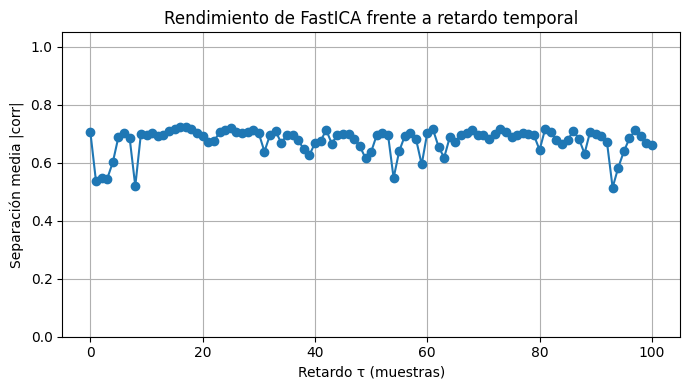

In [45]:

s1 = emg[:, 6]
s2 = emg[:, 27]

taus = np.arange(0, 101, 1)  # 0..50 muestras
scores_ica = []

for tau in taus:
    X, S_ref, S_derived, W = test_fastica_tau(
        s1, s2, tau, crop_mode="valid"
    )

    S_aligned, C_final = match_and_fix(S_ref.T, S_derived.T)

    score = np.mean(np.abs(np.diag(C_final)))
    scores_ica.append(score)

scores = np.array(scores_ica)

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.plot(taus, scores, marker="o")
plt.ylim(0, 1.05)
plt.grid(True)

plt.xlabel("Retardo τ (muestras)")
plt.ylabel("Separación media |corr|")
plt.title("Rendimiento de FastICA frente a retardo temporal")

plt.tight_layout()
plt.show()




# CONCLUSIONES ICA

| Pros de ICA | Contras de ICA |
|------------|----------------|
| Permite separar fuentes **<span style="color:red">ESTADISTICAMENTE INDEPENDIENTES</span>** sin conocer la mezcla | Requiere que las fuentes sean **no gaussianas** (excepto una) |
| No necesita información previa detallada del sistema (modelo ciego) |  Sensible al **ruido** y a mezclas mal condicionadas |
| Puede recuperar señales ocultas en mezclas complejas | Supone **independencia estadística** |
| No requiere sincronización temporal entre fuentes | Resultados pueden variar según inicialización |

Para el caso de la separacion de señales musculares en un EMG, el mayor problema es que los músculos adyacentes presentan **correlacion y coactivación**, dificultando la implementación directa de ICA. 

No obstante existen otros algoritmos y estrategias para enfrentarse a mezclas donde las fuentes son estadísticamente dependientes.

IDEA PARA EVITAR DEPENDENCIA ESTADÍSTICA: Aplicar ICA en **<span style="color:red">frecuencia</span>**

## PCA para encontrar el número de fuentes óptimo



k para 95% var acumulada: 21
k para 99% var acumulada: 28


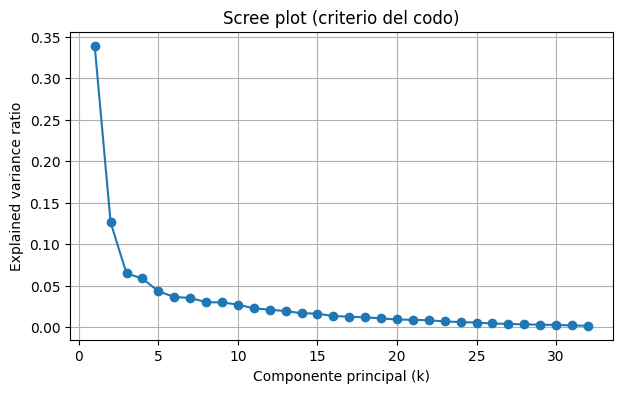

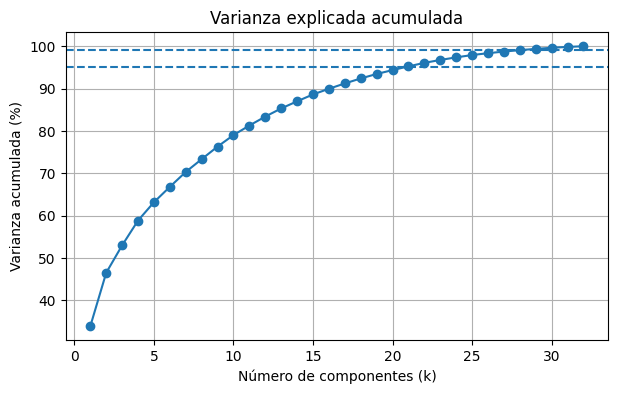

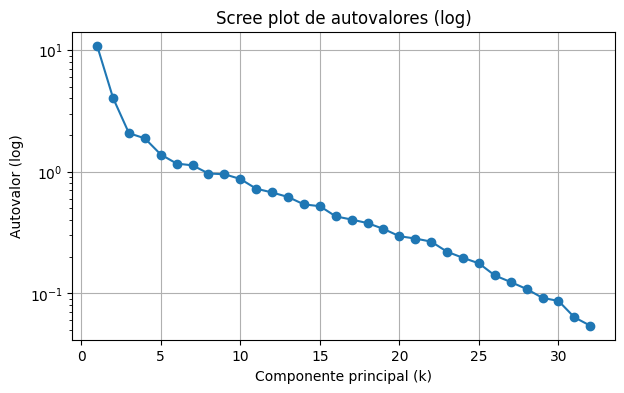

In [ ]:
from sklearn.discriminant_analysis import StandardScaler


Xz = StandardScaler(with_mean=True, with_std=True).fit_transform(emg)
pca = PCA()  # n_components por defecto = min(n_samples, n_features)
pca.fit(Xz)

evr = pca.explained_variance_ratio_            # varianza explicada por componente
cum = np.cumsum(evr)                           # acumulada
eig = pca.explained_variance_                  # autovalores (en escala de varianza)


# Criterios extra típicos por si quieres comparar
k95 = int(np.searchsorted(cum, 0.95) + 1)
k99 = int(np.searchsorted(cum, 0.99) + 1)
print(f"k para 95% var acumulada: {k95}")
print(f"k para 99% var acumulada: {k99}")

# =========================
# PLOTS
# =========================

# 1) Scree plot (varianza explicada por componente)
plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(evr)+1), evr, "o-")
plt.xlabel("Componente principal (k)")
plt.ylabel("Explained variance ratio")
plt.title("Scree plot (criterio del codo)")
plt.grid(True)
plt.show()

# 2) Varianza acumulada
plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(cum)+1), cum*100, "o-")
plt.axhline(95, linestyle="--")
plt.axhline(99, linestyle="--")
plt.xlabel("Número de componentes (k)")
plt.ylabel("Varianza acumulada (%)")
plt.title("Varianza explicada acumulada")
plt.grid(True)
plt.show()

# 3) (Opcional) Autovalores en escala log (a veces se ve mejor el codo)
plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(eig)+1), eig, "o-")
plt.yscale("log")
plt.xlabel("Componente principal (k)")
plt.ylabel("Autovalor (log)")
plt.title("Scree plot de autovalores (log)")
plt.grid(True)
plt.show()

k (Parallel Analysis): 6


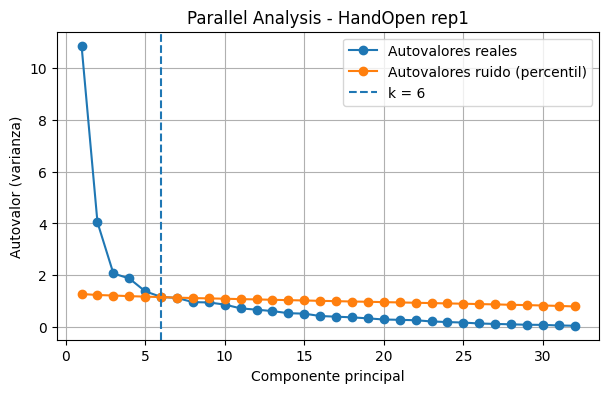

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def parallel_analysis_pca(X, n_iter=200, percentile=95, center=True, random_state=0):
    """
    Parallel Analysis para PCA.

    Parámetros
    ----------
    X : array (n_samples, n_channels)
        Datos reales (ej. EMG). Idealmente ya preprocesados.
    n_iter : int
        Nº de simulaciones de ruido.
    percentile : float
        Percentil del autovalor de ruido (típico: 95).
    center : bool
        Si True, centra por canal antes de PCA.
    random_state : int
        Semilla.

    Devuelve
    --------
    k : int
        Nº de componentes a conservar.
    eig_real : (n_comp,)
        Autovalores reales.
    eig_noise_q : (n_comp,)
        Autovalores de ruido (percentil elegido).
    """
    X = np.asarray(X, float)
    n_samples, n_ch = X.shape
    rng = np.random.default_rng(random_state)

    # centrar por canal
    if center:
        Xc = X - X.mean(axis=0, keepdims=True)
    else:
        Xc = X.copy()

    # PCA real
    pca_real = PCA(n_components=min(n_samples, n_ch), svd_solver="full")
    pca_real.fit(Xc)
    eig_real = pca_real.explained_variance_  # autovalores (varianza) por componente

    n_comp = len(eig_real)

    # PCA en datos aleatorios (ruido blanco) con misma forma
    eig_noise = np.zeros((n_iter, n_comp))
    for i in range(n_iter):
        Xrnd = rng.standard_normal(size=(n_samples, n_ch))
        if center:
            Xrnd = Xrnd - Xrnd.mean(axis=0, keepdims=True)

        pca_rnd = PCA(n_components=n_comp, svd_solver="full")
        pca_rnd.fit(Xrnd)
        eig_noise[i, :] = pca_rnd.explained_variance_

    # percentil por componente
    eig_noise_q = np.percentile(eig_noise, percentile, axis=0)

    # criterio: conservar componentes donde el autovalor real > autovalor ruido
    k = int(np.sum(eig_real > eig_noise_q))
    k = max(k, 1)  # al menos 1

    return k, eig_real, eig_noise_q

def plot_parallel_analysis(eig_real, eig_noise_q, k, title="Parallel Analysis (PCA)"):
    x = np.arange(1, len(eig_real) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(x, eig_real, "o-", label="Autovalores reales")
    plt.plot(x, eig_noise_q, "o-", label="Autovalores ruido (percentil)")

    plt.axvline(k, linestyle="--", label=f"k = {k}")
    plt.xlabel("Componente principal")
    plt.ylabel("Autovalor (varianza)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()
emg = find_movement_rep(mat, "handOpen", rep=1)[0]
emg = eliminar_continua(emg)
emg = eliminar_outiliers(emg, k=8)
emg = escalar_canales(emg, metodo="rms")   # ya escalado
X = emg  # (n_samples, n_channels)

k_pa, eig_real, eig_noise_q = parallel_analysis_pca(
    X, n_iter=200, percentile=95, center=True, random_state=0
)

print("k (Parallel Analysis):", k_pa)

plot_parallel_analysis(eig_real, eig_noise_q, k_pa,
                       title="Parallel Analysis - HandOpen rep1")



## Aplicar ICA a para k componentes

In [ ]:
k = 6 #Cambiar en funcion de las anteriores celdas !!!!
pca = PCA(n_components=k, svd_solver="full")
Z = pca.fit_transform(Xc)

ica = FastICA(n_components=k, whiten="unit-variance",
              random_state=0, max_iter=4000, tol=1e-6)
S_hat = ica.fit_transform(Z)

NameError: name 'Xc' is not defined

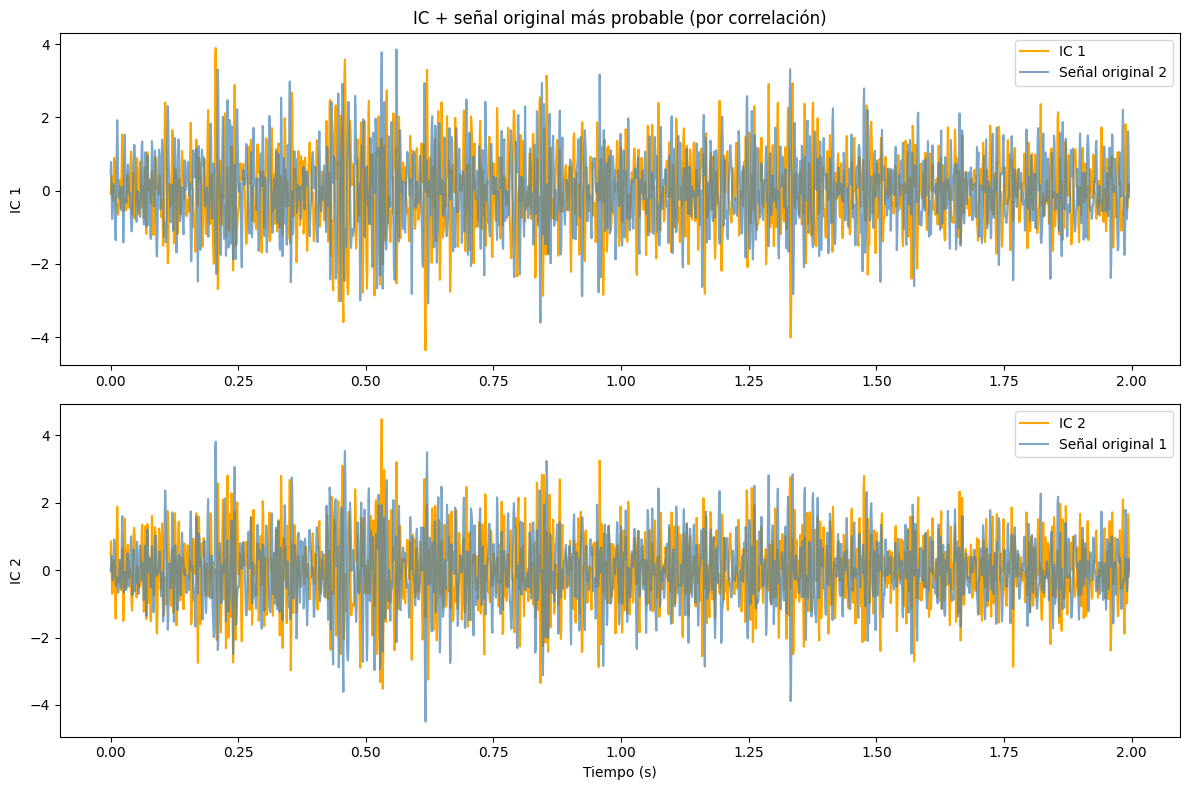

Correlación canal ↔ componente (original vs ICA):
 [[ 0.99305152  0.1176804 ]
 [-0.32465108  0.94583385]]


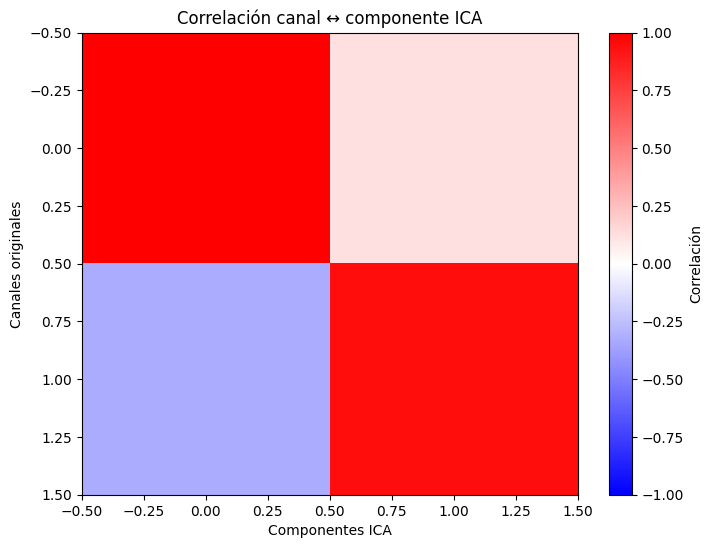

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

# ----------------------------
# Parámetros
# ----------------------------
beta = 0.8
delay_samples = 5  # retardo temporal en muestras
ch1_idx = 1        # índice del primer canal
ch2_idx = 20     # índice del segundo canal

# ----------------------------
# 1️⃣ Crear canales mezclados con retardo
# ----------------------------
# Recortar para que coincidan longitudes
min_len = emg_norm.shape[0] - delay_samples
c1 = emg_norm[:min_len, ch1_idx] + beta * emg_norm[delay_samples:, ch2_idx]
c2 = emg_norm[:min_len, ch2_idx] + beta * emg_norm[delay_samples:, ch1_idx]

# Combinar en matriz para ICA
X = np.column_stack([c1, c2])
n_channels = X.shape[1]

# ----------------------------
# 2️⃣ Aplicar ICA
# ----------------------------
ica = FastICA(n_components=n_channels, random_state=0, algorithm='deflation', max_iter=1000)
S_ = ica.fit_transform(X)  # componentes independientes
A_ = ica.mixing_           # matriz de mezcla

# Reconstrucción (para comparar si quieres)
emg_recon = S_ @ A_.T

# ----------------------------
# 3️⃣ Tiempo
# ----------------------------
fs = 1000
t = np.arange(min_len) / fs

# ----------------------------
# 4️⃣ Plot: Componente ICA + señal original más probable
# ----------------------------
plt.figure(figsize=(12, 4*n_channels))

for i in range(n_channels):
    # Señal original más correlacionada con el IC i
    idx_orig = np.argmax(np.abs(corr_matrix[:, i]))
    orig_signal = X[:, idx_orig]

    # Normalizar para comparar escalas
    ic_norm = S_[:, i] / np.std(S_[:, i])
    orig_norm = orig_signal / np.std(orig_signal)

    plt.subplot(n_channels, 1, i+1)
    plt.plot(t, ic_norm, label=f'IC {i+1}', color='orange', linewidth=1.5)
    plt.plot(t, orig_norm, label=f'Señal original {idx_orig+1}', 
             color='steelblue', alpha=0.7)

    plt.ylabel(f'IC {i+1}')
    plt.legend(loc='upper right')

    if i == 0:
        plt.title('IC + señal original más probable (por correlación)')
    if i == n_channels - 1:
        plt.xlabel('Tiempo (s)')

plt.tight_layout()
plt.show()

# 5️⃣ Correlación canal ↔ componente
# ----------------------------
corr_matrix = np.corrcoef(X.T, S_.T)[:n_channels, n_channels:]
print("Correlación canal ↔ componente (original vs ICA):\n", corr_matrix)

plt.figure(figsize=(8,6))
plt.imshow(corr_matrix, cmap='bwr', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(label='Correlación')
plt.xlabel('Componentes ICA')
plt.ylabel('Canales originales')
plt.title('Correlación canal ↔ componente ICA')
plt.show()


## Encontrar el número de grupos (PCA)

# SOBI: Separación de fuentes con retardos

## Modelo de mezcla con retardo

$$
\begin{cases}
c_1(t) = s_1(t) + \beta\, s_2(t-\tau) \\
c_2(t) = s_2(t) + \beta\, s_1(t-\tau)
\end{cases}
$$


### 1. Centrado

$$
\tilde{\mathbf{X}} = \mathbf{X} - \mathbb{E}[\mathbf{X}]
$$



### 2. Covarianza (retardo cero)

$$
\mathbf{R}_x(0) = \mathbb{E}\left[\tilde{\mathbf{X}}(t) \tilde{\mathbf{X}}^T(t)\right]
$$



### 3️. Blanqueo (Whitening)

$$
\mathbf{R}_x(0) = \mathbf{E} \mathbf{D} \mathbf{E}^T
$$

$$
\mathbf{V} = \mathbf{E} \mathbf{D}^{-1/2}, \quad
\mathbf{Z}(t) = \mathbf{V}^T \tilde{\mathbf{X}}(t)
$$



### 4️. Autocorrelación con retardos

Para cada retardo $\tau_k$:

$$
\mathbf{R}_z(\tau_k) = \mathbb{E}\left[\mathbf{Z}(t) \mathbf{Z}^T(t-\tau_k)\right]
$$



## 5️. Diagonalización conjunta (SOBI)

$$
\mathbf{U}^T \mathbf{R}_z(\tau_k) \mathbf{U} \approx \text{diagonal}, \quad \forall \tau_k
$$



## 6️. Estimación de fuentes

$$
\mathbf{W} = \mathbf{V} \mathbf{U}, \quad
\mathbf{S}(t) = \mathbf{X} \mathbf{W}
$$

**Notas:**
- $\mathbf{S}$: fuentes estimadas (cada columna = fuente)  
- $\mathbf{W}$: matriz de separación  
- Ambigüedad: escala, signo y orden de las fuentes


In [ ]:
from aux_func import sobi  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Parámetros
# ----------------------------
beta = 0.8
delay_samples = 5
ch1_idx = 1
ch2_idx = 20
fs = 1000

# ----------------------------
# 0) Definir "fuentes" (para test)
# ----------------------------
s1 = emg_norm[:, ch1_idx].copy()
s2 = emg_norm[:, ch2_idx].copy()

# ----------------------------
# 1) Mezcla con retardo (como tú definiste)
# ----------------------------
min_len = len(s1) - delay_samples
s1_trim = s1[:min_len]
s2_trim = s2[:min_len]

c1 = s1_trim + beta * s2[delay_samples:delay_samples + min_len]
c2 = s2_trim + beta * s1[delay_samples:delay_samples + min_len]

X = np.column_stack([c1, c2])  # (samples, channels)

# (Opcional) NO z-score por ahora; SOBI ya centra.
# X = (X - X.mean(axis=0)) / X.std(axis=0)

# ----------------------------
# 2) Aplicar SOBI
# ----------------------------
lags = [1, 2, 5, 10, 15, 20]
S_, W_ = sobi(X, delays=lags, n_sources=2)

# ----------------------------
# 3) Tiempo
# ----------------------------
t = np.arange(min_len) / fs

# ----------------------------
# 4) Evaluación correcta: correlación fuentes ↔ componentes
# ----------------------------
true_sources = np.column_stack([s1_trim, s2_trim])
corr = np.corrcoef(true_sources.T, S_.T)[:2, 2:]
print("Correlación (fuentes reales vs componentes SOBI):\n", corr)

plt.figure(figsize=(6, 4))
plt.imshow(corr, vmin=-1, vmax=1, aspect="auto")
plt.colorbar(label="Correlación")
plt.xticks([0, 1], ["SOBI1", "SOBI2"])
plt.yticks([0, 1], ["s1", "s2"])
plt.title("Correlación: fuentes reales ↔ SOBI")
plt.show()

# (Opcional) ver señales
plt.figure(figsize=(10,6))
plt.subplot(3,1,1); plt.plot(t, c1); plt.plot(t, c2, alpha=0.7); plt.title("Mezclas c1, c2")
plt.subplot(3,1,2); plt.plot(t, S_[:,0]); plt.plot(t, S_[:,1], alpha=0.7); plt.title("Componentes SOBI")
plt.subplot(3,1,3); plt.plot(t, s1_trim); plt.plot(t, s2_trim, alpha=0.7); plt.title("Fuentes (referencia)")
plt.tight_layout()
plt.show()


NameError: name 'emg_norm' is not defined

Correlación canal ↔ componente (original vs SOBI):
 [[ 0.2801238   0.83867826 -0.30822449 -0.34855344  0.04071365]
 [ 0.70858336  0.48854998  0.21841201  0.41884108 -0.18999178]
 [ 0.2030092  -0.50466706  0.75520723 -0.14244012  0.33685498]
 [-0.29453054 -0.13438645  0.31377151 -0.41372243 -0.79093188]
 [-0.61944033  0.52736296  0.31977268  0.32962162  0.35675904]]


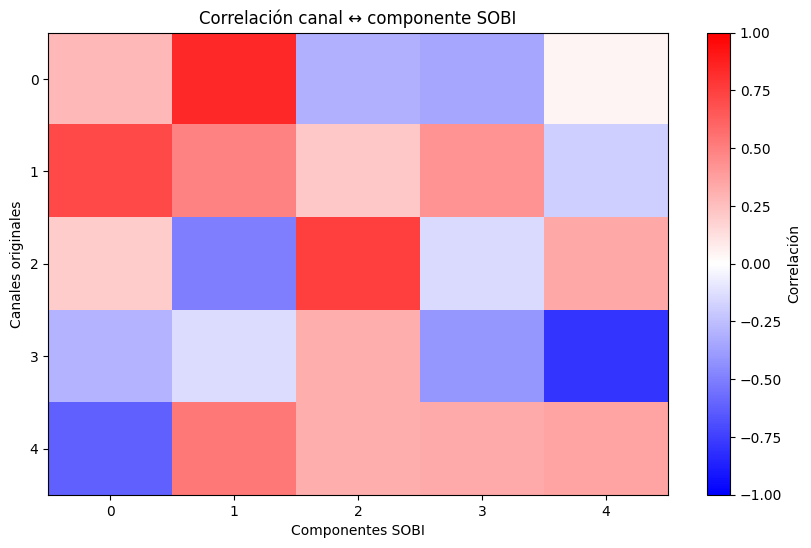

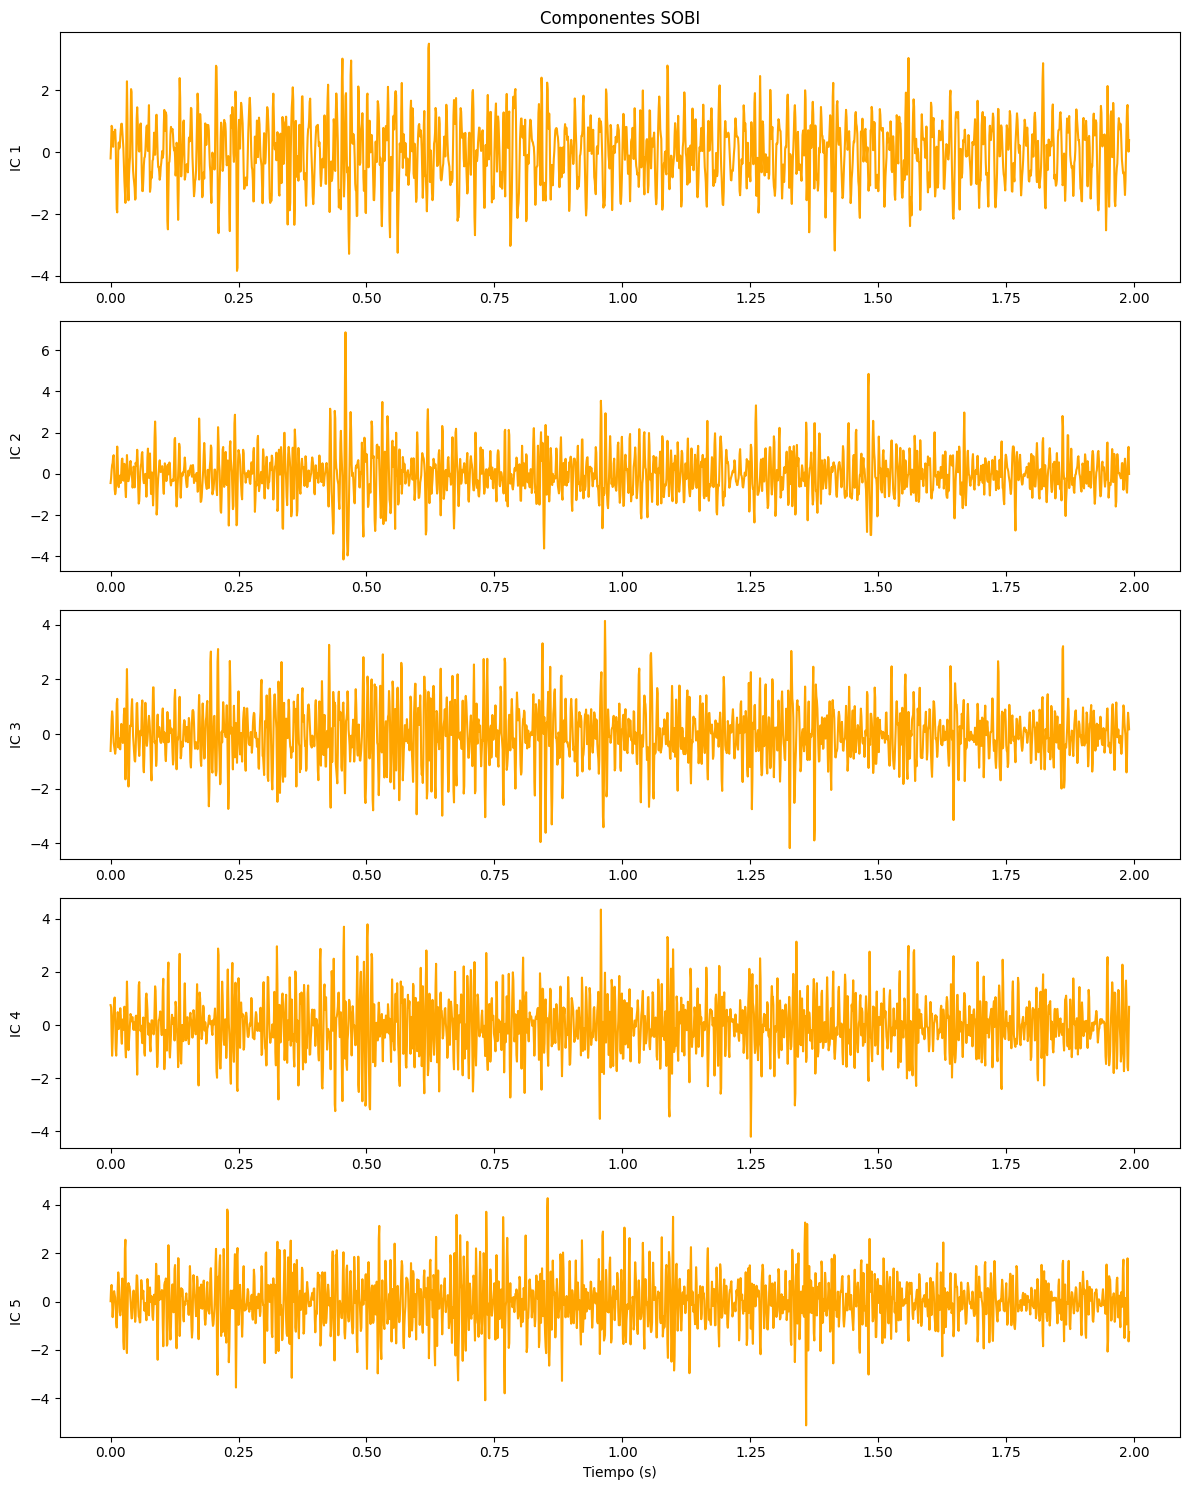

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from aux_func import sobi  # asegúrate de tener la función SOBI implementada

# ----------------------------
# Parámetros
# ----------------------------
beta = 0.2
delay_samples = 10       # retardo temporal en muestras
channels_idx = [1, 5, 10, 15, 20]  # índices de los canales originales
n_channels = len(channels_idx)

# ----------------------------
# 1️⃣ Crear canales mezclados con retardo
# ----------------------------
min_len = emg_norm.shape[0] - delay_samples
X_mix = []

for i, ch in enumerate(channels_idx):
    # Mezcla simple: cada canal suma beta * otro canal desplazado
    next_ch = channels_idx[(i+1) % n_channels]  # canal siguiente para mezclar
    c = emg_norm[:min_len, ch] + beta * emg_norm[delay_samples:, next_ch]
    X_mix.append(c)

# Matriz de señales mezcladas
X = np.column_stack(X_mix)

# ----------------------------
# Normalizar canales
# ----------------------------
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# ----------------------------
# 2️⃣ Aplicar SOBI
# ----------------------------
# Retardos relevantes para EMG
lags = [1, 2, 5, 10, 15, 20]

S_, W_ = sobi(X, delays=lags, n_sources=n_channels)
emg_recon = S_ @ W_.T  # reconstrucción opcional

# ----------------------------
# 3️⃣ Tiempo
# ----------------------------
fs = 1000
t = np.arange(min_len) / fs

# ----------------------------
# 4️⃣ Correlación canal ↔ componente
# ----------------------------
corr_matrix = np.corrcoef(X.T, S_.T)[:n_channels, n_channels:]
print("Correlación canal ↔ componente (original vs SOBI):\n", corr_matrix)

plt.figure(figsize=(10, 6))
plt.imshow(corr_matrix, cmap='bwr', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(label='Correlación')
plt.xlabel('Componentes SOBI')
plt.ylabel('Canales originales')
plt.title('Correlación canal ↔ componente SOBI')
plt.show()

# ----------------------------
# 5️⃣ Plot de componentes SOBI
# ----------------------------
plt.figure(figsize=(12, 3*n_channels))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i+1)
    plt.plot(t, S_[:, i], label=f'SOBI IC {i+1}', color='orange')
    plt.ylabel(f'IC {i+1}')
    if i == 0:
        plt.title('Componentes SOBI')
    if i == n_channels-1:
        plt.xlabel('Tiempo (s)')
plt.tight_layout()
plt.show()


Correlación canal ↔ componente (original vs SOBI):
 [[ 0.28286338  0.83737603 -0.310876   -0.34804219  0.03181883]
 [ 0.70907771  0.48588002  0.21078473  0.42950484 -0.17951268]
 [ 0.20448901 -0.49996357  0.75962098 -0.15003408  0.32967622]
 [-0.29332191 -0.13105026  0.31405553 -0.38958467 -0.80397823]
 [-0.61750321  0.53019682  0.31867016  0.32092405  0.36474403]]


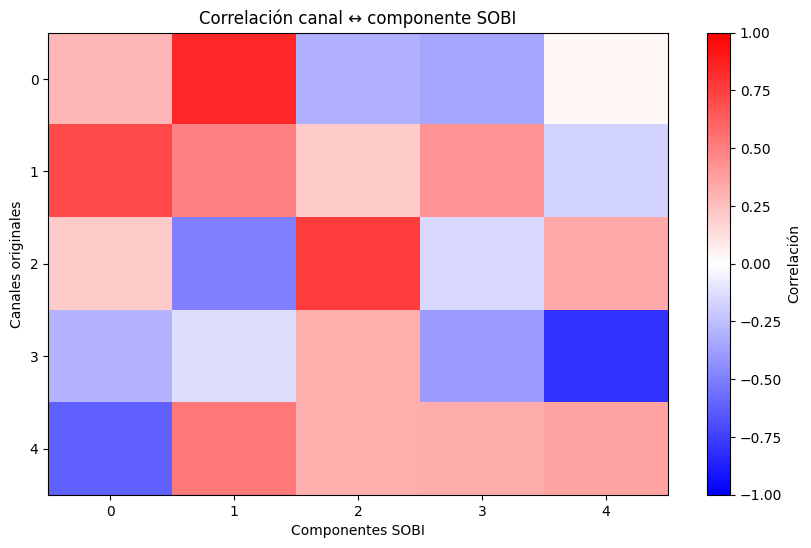

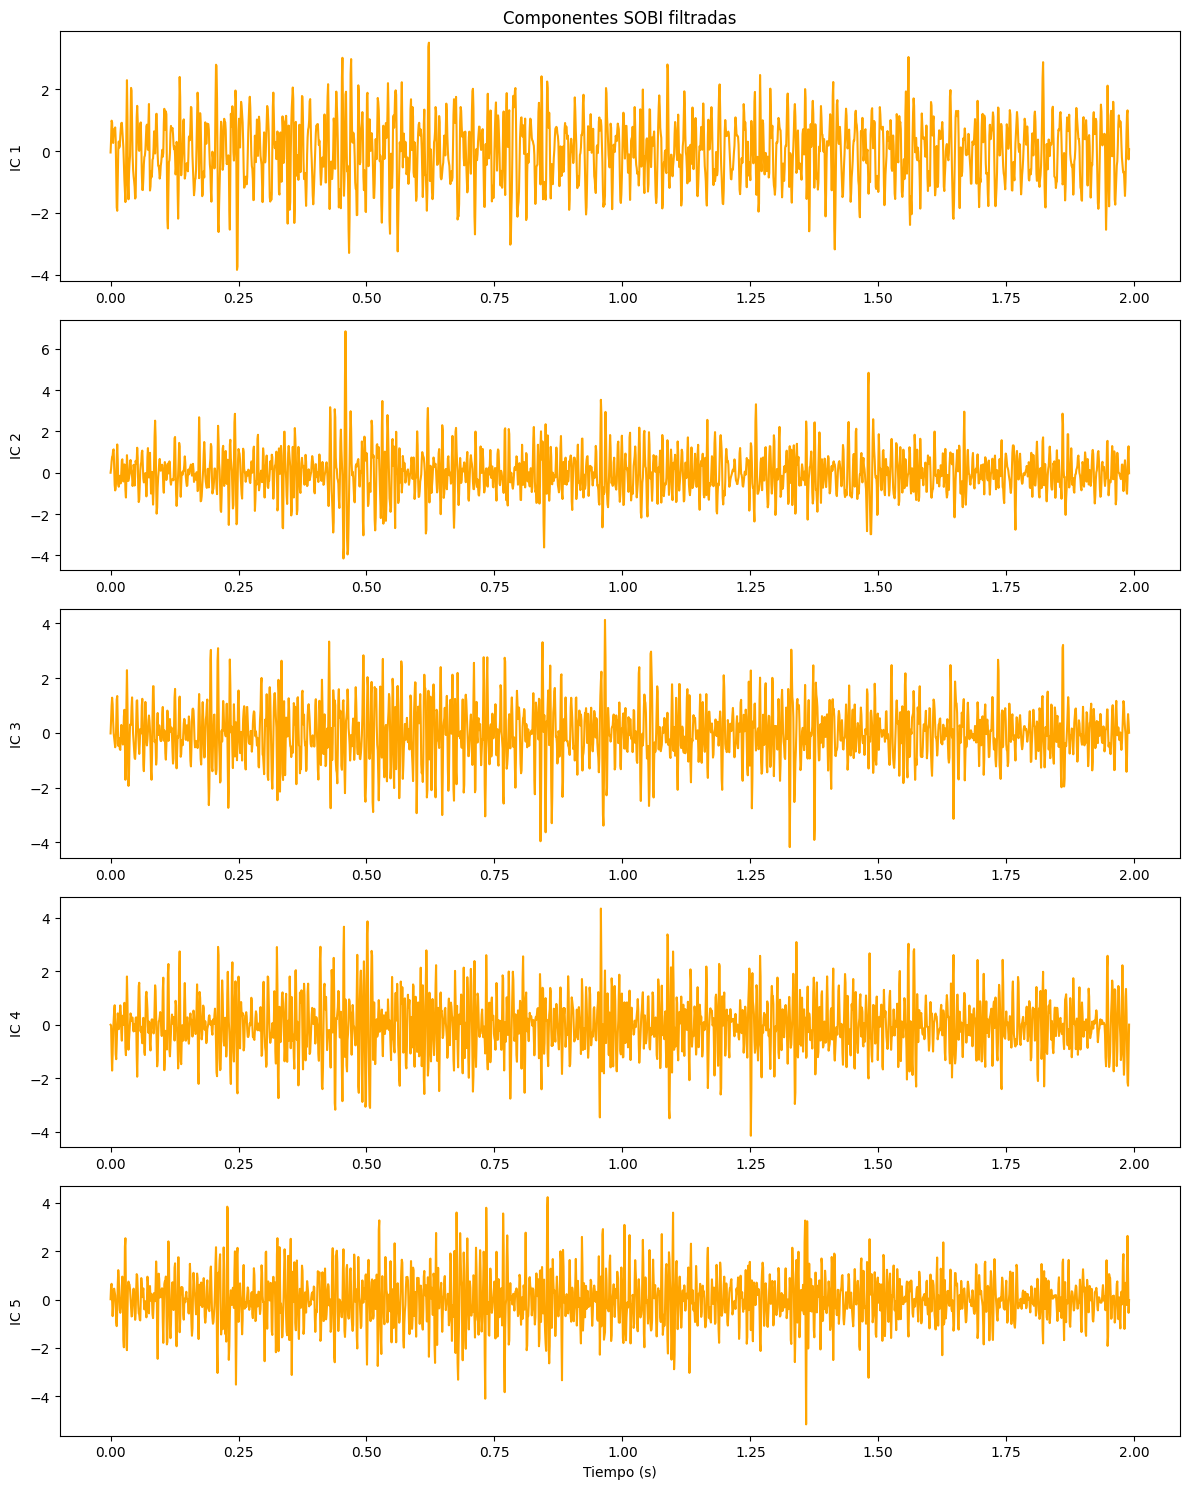

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from aux_func import sobi  # tu función SOBI

# ----------------------------
# Parámetros
# ----------------------------
beta = 0.2
delay_samples = 10
channels_idx = [1, 5, 10, 15, 20]  # canales
n_channels = len(channels_idx)
fs = 1000  # Hz

# ----------------------------
# 0️⃣ Filtro pasa-banda EMG
# ----------------------------
def bandpass_filter(signal, fs, lowcut=20, highcut=450, order=12):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, signal)

# ----------------------------
# 1️⃣ Crear canales filtrados y mezclados
# ----------------------------
min_len = emg_norm.shape[0] - delay_samples
X_mix = []

for i, ch in enumerate(channels_idx):
    sig = emg_norm[:min_len, ch]
    sig = bandpass_filter(sig, fs)  # aplicar filtro
    next_ch = channels_idx[(i+1) % n_channels]
    sig_next = bandpass_filter(emg_norm[delay_samples:, next_ch], fs)
    c = sig + beta * sig_next
    X_mix.append(c)

X = np.column_stack(X_mix)

# ----------------------------
# 2️⃣ Normalizar canales
# ----------------------------
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# ----------------------------
# 3️⃣ Aplicar SOBI
# ----------------------------
lags = [1, 2, 5, 10, 15, 20]
S_, W_ = sobi(X, delays=lags, n_sources=n_channels)
emg_recon = S_ @ W_.T

# ----------------------------
# 4️⃣ Tiempo
# ----------------------------
t = np.arange(min_len) / fs

# ----------------------------
# 5️⃣ Correlación canal ↔ componente
# ----------------------------
corr_matrix = np.corrcoef(X.T, S_.T)[:n_channels, n_channels:]
print("Correlación canal ↔ componente (original vs SOBI):\n", corr_matrix)

plt.figure(figsize=(10,6))
plt.imshow(corr_matrix, cmap='bwr', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(label='Correlación')
plt.xlabel('Componentes SOBI')
plt.ylabel('Canales originales')
plt.title('Correlación canal ↔ componente SOBI')
plt.show()

# ----------------------------
# 6️⃣ Plot de componentes SOBI
# ----------------------------
plt.figure(figsize=(12, 3*n_channels))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i+1)
    plt.plot(t, S_[:, i], label=f'SOBI IC {i+1}', color='orange')
    plt.ylabel(f'IC {i+1}')
    if i == 0:
        plt.title('Componentes SOBI filtradas')
    if i == n_channels-1:
        plt.xlabel('Tiempo (s)')
plt.tight_layout()
plt.show()


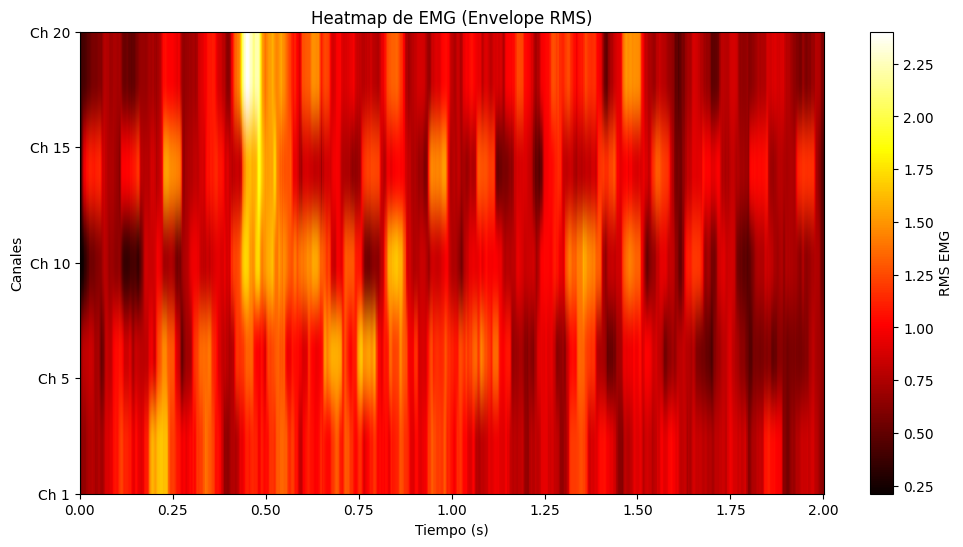

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ----------------------------
# Parámetros
# ----------------------------
fs = 1000  # Hz
channels_idx = [1, 5, 10, 15, 20]  # canales a mostrar
min_len = emg_norm.shape[0]
n_channels = len(channels_idx)

# ----------------------------
# Filtro pasa-banda EMG
# ----------------------------
def bandpass_filter(signal, fs, lowcut=20, highcut=450, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, signal)

# ----------------------------
# Construir matriz filtrada
# ----------------------------
X_filtered = []
for ch in channels_idx:
    sig = emg_norm[:min_len, ch]
    sig = bandpass_filter(sig, fs)
    X_filtered.append(sig)

X_filtered = np.array(X_filtered)  # shape: (n_channels, n_samples)

# ----------------------------
# Calcular envelope RMS
# ----------------------------
def rms_envelope(signal, window_ms=50, fs=1000):
    window_samples = int(window_ms * fs / 1000)
    return np.sqrt(np.convolve(signal**2, np.ones(window_samples)/window_samples, mode='same'))

X_rms = np.array([rms_envelope(ch_sig, window_ms=50, fs=fs) for ch_sig in X_filtered])

# ----------------------------
# Heatmap
# ----------------------------
plt.figure(figsize=(12, 6))
plt.imshow(X_rms, aspect='auto', cmap='hot', extent=[0, min_len/fs, 1, n_channels])
plt.colorbar(label='RMS EMG')
plt.yticks(range(1, n_channels+1), [f'Ch {ch}' for ch in channels_idx])
plt.xlabel('Tiempo (s)')
plt.ylabel('Canales')
plt.title('Heatmap de EMG (Envelope RMS)')
plt.show()


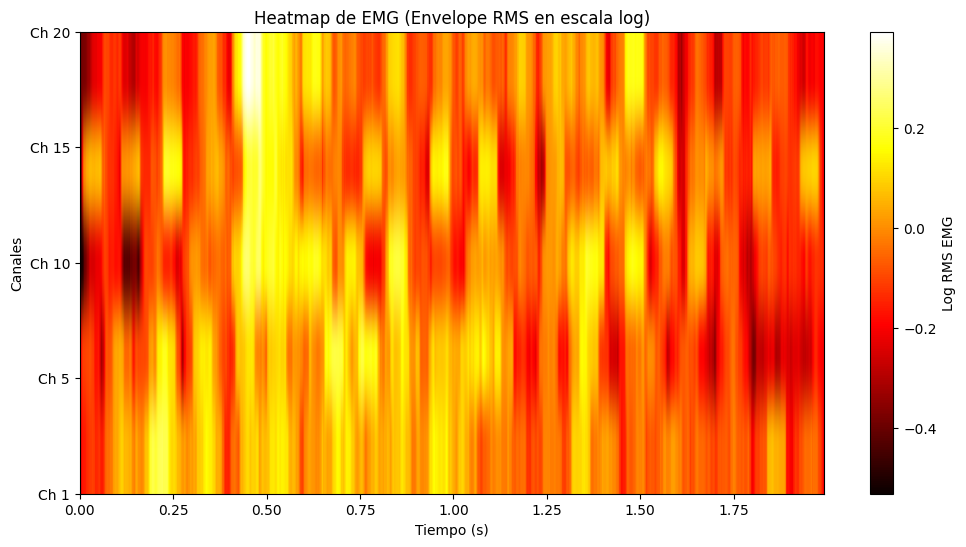

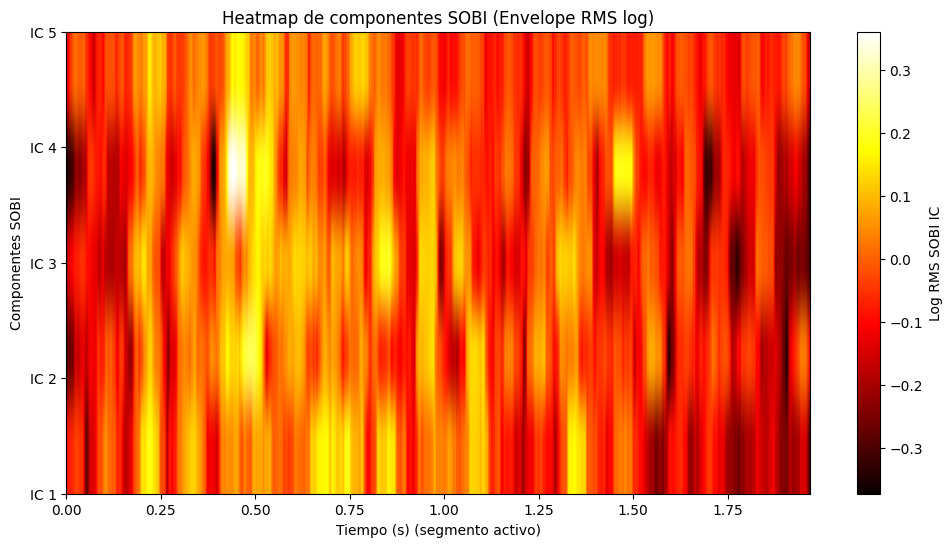

Correlación canal ↔ componente SOBI:
 [[ 0.27777642  0.84028451 -0.2987266  -0.35460634  0.04217779]
 [ 0.70718413  0.49115055  0.22046275  0.4184728  -0.18691825]
 [ 0.20233895 -0.51425806  0.75377443 -0.13546885  0.32873987]
 [-0.29383386 -0.14040567  0.30956948 -0.40513673 -0.7962279 ]
 [-0.62027339  0.52375031  0.32440219  0.32538624  0.36032422]]


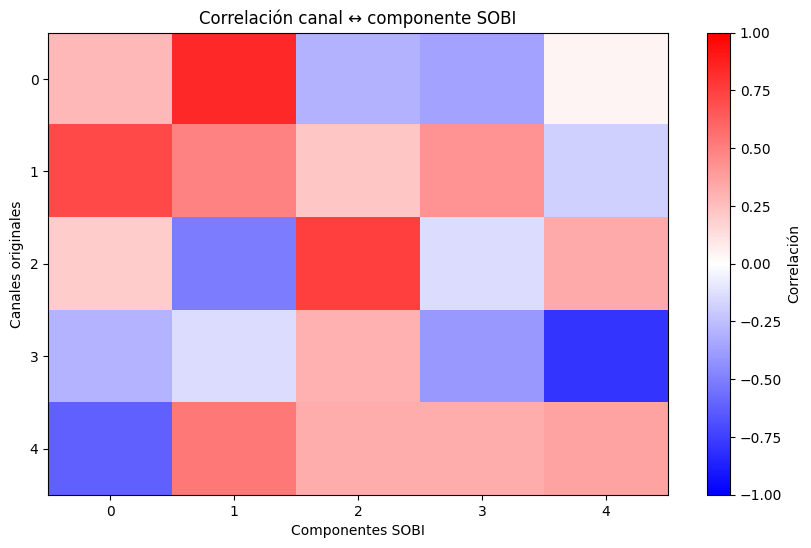

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from aux_func import sobi  # tu SOBI que acepta delays=...

# ----------------------------
# Parámetros
# ----------------------------
fs = 1000  # Hz
channels_idx =[1, 5, 10, 15, 20]  #
n_channels = len(channels_idx)
beta = 0.2
delay_samples = 10

# ----------------------------
# 0️⃣ Filtro pasa-banda EMG
# ----------------------------
def bandpass_filter(x, fs, lowcut=20, highcut=450, order=4):
    x = np.asarray(x, dtype=float)
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype="band")
    # OJO: filtfilt necesita suficiente longitud
    padlen = 3 * (max(len(a), len(b)) - 1)
    if x.size <= padlen:
        # Si es muy corto, devuelve sin filtrar para evitar error
        return x
    return filtfilt(b, a, x)

# ----------------------------
# 2️⃣ RMS envelope
# ----------------------------
def rms_envelope(x, window_ms=50, fs=1000):
    x = np.asarray(x, dtype=float)
    window_samples = max(1, int(window_ms * fs / 1000))
    kernel = np.ones(window_samples) / window_samples
    return np.sqrt(np.convolve(x**2, kernel, mode="same"))

# ----------------------------
# 1️⃣ Construir matriz filtrada (channels, samples)
# ----------------------------
min_len = emg_norm.shape[0] - delay_samples
X_filtered = []

for i, ch in enumerate(channels_idx):
    sig = emg_norm[:min_len, ch]
    sig = bandpass_filter(sig, fs)

    # Mezcla simple con "siguiente" canal con retardo
    next_ch = channels_idx[(i + 1) % n_channels]
    sig_next = emg_norm[delay_samples:delay_samples + min_len, next_ch]
    sig_next = bandpass_filter(sig_next, fs)

    X_filtered.append(sig + beta * sig_next)

X_filtered = np.array(X_filtered)  # (n_channels, n_samples)

# ----------------------------
# 2️⃣ Segmentación por activación (umbral RMS)
# ----------------------------
X_rms = np.array([rms_envelope(ch_sig, window_ms=50, fs=fs) for ch_sig in X_filtered])

threshold = 0.3 * np.max(X_rms)  # 30% del máximo global
active_mask = np.any(X_rms > threshold, axis=0)  # (n_samples,)

X_active = X_filtered[:, active_mask]  # (n_channels, n_active_samples)

if X_active.shape[1] < 100:
    raise ValueError("Muy pocas muestras activas tras el umbral. Baja el threshold o revisa la RMS.")

# ----------------------------
# 3️⃣ Normalizar canales (por canal)
# ----------------------------
mu = np.mean(X_active, axis=1, keepdims=True)
sd = np.std(X_active, axis=1, keepdims=True)
sd = np.maximum(sd, 1e-12)
X_active = (X_active - mu) / sd  # (n_channels, n_active_samples)

# ----------------------------
# 4️⃣ Aplicar SOBI
#    SOBI espera (n_samples, n_channels) => transponemos
# ----------------------------
lags = [1, 2, 5, 10, 15, 20]

X_sobi_in = X_active.T  # (n_active_samples, n_channels)
S_est, W_est = sobi(X_sobi_in, delays=lags, n_sources=n_channels)

# S_est: (n_active_samples, n_sources)
# Para heatmaps como tú lo pintas: (n_sources, n_active_samples)
S_ = S_est.T

# ----------------------------
# 5️⃣ Heatmap EMG original (log RMS)
# ----------------------------
X_rms_log = np.log10(X_rms + 1e-6)

plt.figure(figsize=(12, 6))
plt.imshow(
    X_rms_log,
    aspect="auto",
    cmap="hot",
    extent=[0, min_len / fs, 1, n_channels],
)
plt.colorbar(label="Log RMS EMG")
plt.yticks(range(1, n_channels + 1), [f"Ch {ch}" for ch in channels_idx])
plt.xlabel("Tiempo (s)")
plt.ylabel("Canales")
plt.title("Heatmap de EMG (Envelope RMS en escala log)")
plt.show()

# ----------------------------
# 6️⃣ Heatmap de componentes SOBI (log)
# ----------------------------
S_rms = np.array([rms_envelope(ic, window_ms=50, fs=fs) for ic in S_])
S_rms_log = np.log10(S_rms + 1e-6)

# OJO: el tiempo aquí es "tiempo en segmento activo" (no el original continuo)
t_active = np.arange(X_active.shape[1]) / fs

plt.figure(figsize=(12, 6))
plt.imshow(
    S_rms_log,
    aspect="auto",
    cmap="hot",
    extent=[0, t_active[-1], 1, n_channels],
)
plt.colorbar(label="Log RMS SOBI IC")
plt.yticks(range(1, n_channels + 1), [f"IC {i+1}" for i in range(n_channels)])
plt.xlabel("Tiempo (s) (segmento activo)")
plt.ylabel("Componentes SOBI")
plt.title("Heatmap de componentes SOBI (Envelope RMS log)")
plt.show()

# ----------------------------
# 7️⃣ Correlación canal ↔ componente SOBI
#    Correlación entre (n_active_samples) series temporales
# ----------------------------
# X_active: (n_channels, n_active_samples)
# S_      : (n_sources,  n_active_samples)
Xc = X_active.T  # (samples, channels)
Sc = S_.T        # (samples, sources)

# corrcoef necesita variables en filas => ponemos (channels/sources, samples)
corr_full = np.corrcoef(np.vstack([X_active, S_]))  # (ch+src, ch+src)
corr_matrix = corr_full[:n_channels, n_channels:]   # (ch, src)

print("Correlación canal ↔ componente SOBI:\n", corr_matrix)

plt.figure(figsize=(10, 6))
plt.imshow(corr_matrix, cmap="bwr", vmin=-1, vmax=1, aspect="auto")
plt.colorbar(label="Correlación")
plt.xlabel("Componentes SOBI")
plt.ylabel("Canales originales")
plt.title("Correlación canal ↔ componente SOBI")
plt.show()


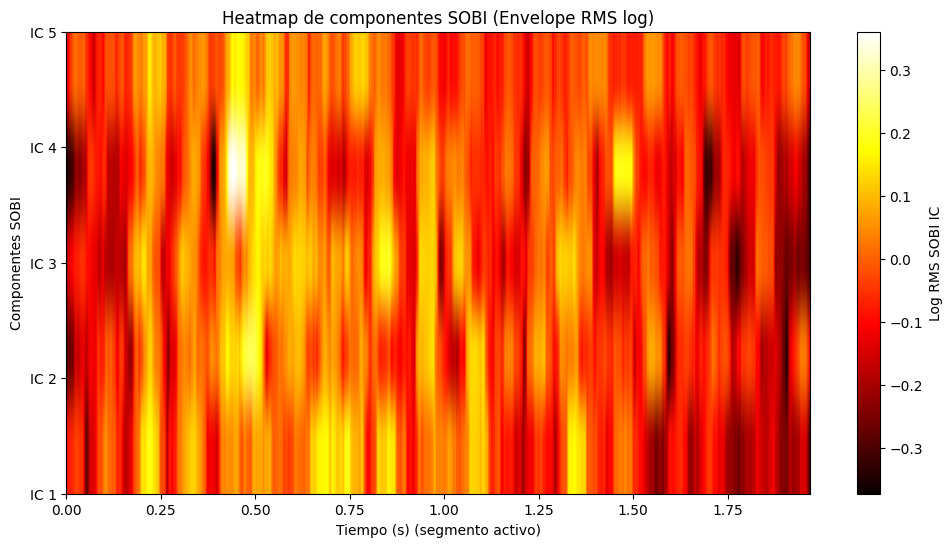

In [ ]:
# OJO: el tiempo aquí es "tiempo en segmento activo" (no el original continuo)
t_active = np.arange(X_active.shape[1]) / fs

plt.figure(figsize=(12, 6))
plt.imshow(
    S_rms_log,
    aspect="auto",
    cmap="hot",
    extent=[0, t_active[-1], 1, n_channels],
)
plt.colorbar(label="Log RMS SOBI IC")
plt.yticks(range(1, n_channels + 1), [f"IC {i+1}" for i in range(n_channels)])
plt.xlabel("Tiempo (s) (segmento activo)")
plt.ylabel("Componentes SOBI")
plt.title("Heatmap de componentes SOBI (Envelope RMS log)")
plt.show()

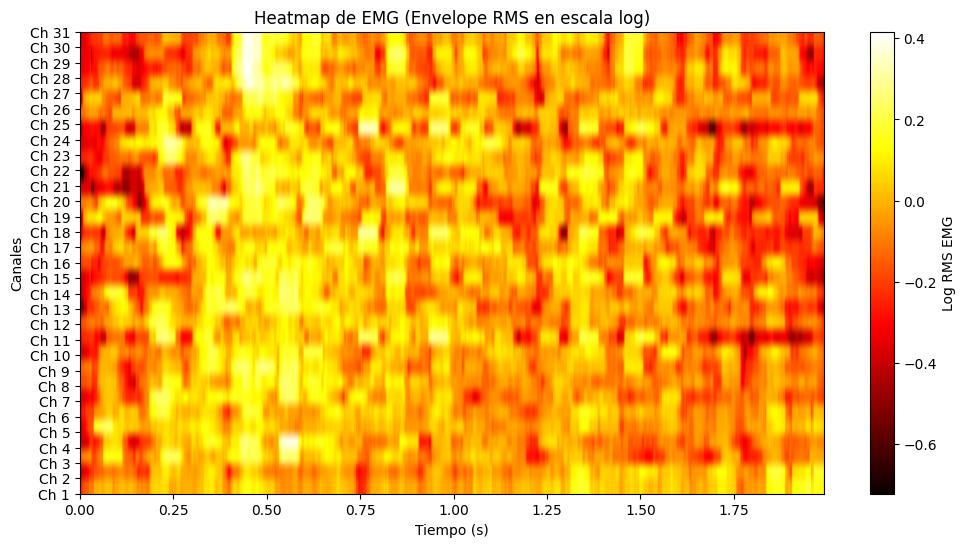

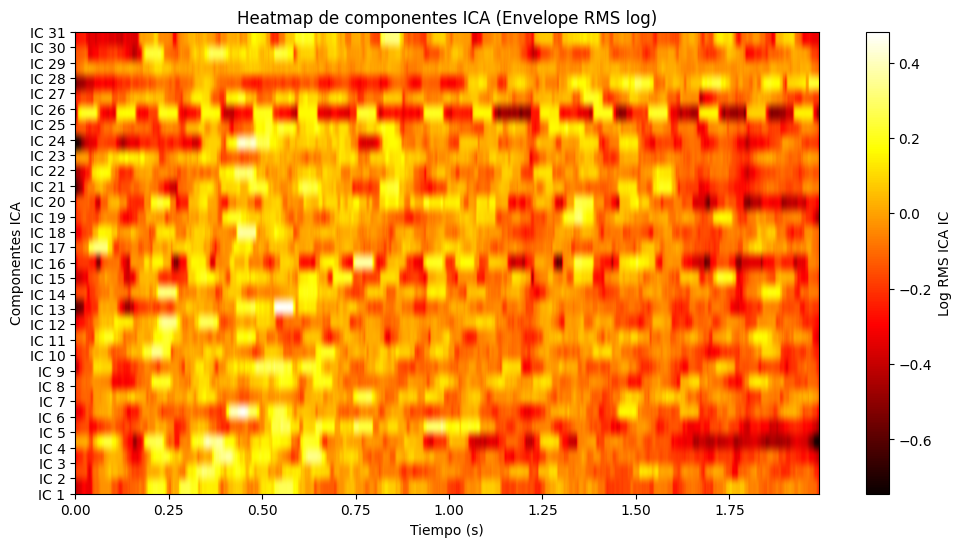

Correlación canal ↔ componente ICA:
 [[-3.81629158e-02  8.09297013e-02  2.95758714e-01 -1.76385063e-02
  -9.07499017e-03 -1.91887396e-02  2.78660904e-01  5.63482691e-01
  -1.34253799e-01 -1.68237608e-01 -4.60434966e-02 -7.68209317e-03
   9.52373569e-02 -3.34585255e-01 -6.31941376e-02 -8.43464470e-02
   1.78329360e-01  3.02924544e-01  2.42872321e-01  3.22433858e-02
  -2.01369524e-03  5.37744758e-02  7.58638772e-03  6.43909604e-02
   3.95543423e-02 -3.35998692e-01 -1.76010602e-02  5.60887970e-02
   1.09745860e-01  7.10285542e-02  4.76110120e-02]
 [-5.32073503e-01  9.51660047e-02  5.35244019e-02 -8.03276190e-03
   2.28177370e-02 -8.97908591e-03  4.87387212e-02  5.83081126e-01
  -1.00250560e-01 -1.24888829e-01 -4.44747426e-03  1.16775487e-02
  -7.71710646e-02 -7.44324042e-02  4.70354119e-03 -3.73678126e-02
   4.27094300e-01  1.22973311e-01  1.52292823e-01  8.71163854e-02
   2.89086005e-02  2.41185967e-02  1.27309544e-01  8.52956685e-02
   1.00703401e-02 -2.46218041e-01  2.01662270e-03  4.2

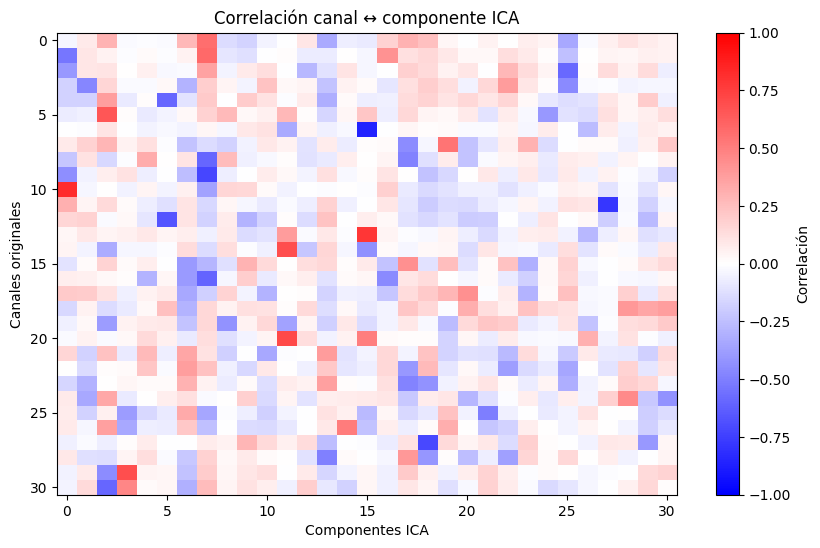

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.decomposition import FastICA

# ----------------------------
# Parámetros
# ----------------------------
fs = 1000  # Hz
channels_idx = np.arange(1, 32)  # canales a usar
n_channels = len(channels_idx)
beta = 0.2
delay_samples = 10

# ----------------------------
# 0️⃣ Filtro pasa-banda EMG
# ----------------------------
def bandpass_filter(signal, fs, lowcut=20, highcut=450, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, signal)

# ----------------------------
# 1️⃣ Construir matriz filtrada
# ----------------------------
min_len = emg_norm.shape[0] - delay_samples
X_filtered = []

for i, ch in enumerate(channels_idx):
    sig = emg_norm[:min_len, ch]
    sig = bandpass_filter(sig, fs)
    
    # Mezcla simple con siguiente canal (retardo)
    next_ch = channels_idx[(i+1) % n_channels]
    sig_next = bandpass_filter(emg_norm[delay_samples:, next_ch], fs)
    X_filtered.append(sig + beta * sig_next)

X_filtered = np.array(X_filtered)  # shape: (n_channels, n_samples)

# ----------------------------
# 2️⃣ Segmentación por activación (umbral RMS)
# ----------------------------
def rms_envelope(signal, window_ms=50, fs=1000):
    window_samples = int(window_ms * fs / 1000)
    return np.sqrt(np.convolve(signal**2, np.ones(window_samples)/window_samples, mode='same'))

X_rms = np.array([rms_envelope(ch_sig, window_ms=50, fs=fs) for ch_sig in X_filtered])

# Umbral automático: 30% de la máxima amplitud
threshold = 0.3 * np.max(X_rms)
active_mask = np.any(X_rms > threshold, axis=0)

# Seleccionar solo segmentos activos
X_active = X_filtered[:, active_mask]

# ----------------------------
# 3️⃣ Normalizar canales
# ----------------------------
X_active = (X_active - np.mean(X_active, axis=1, keepdims=True)) / np.std(X_active, axis=1, keepdims=True)

# ----------------------------
# 4️⃣ Aplicar ICA
# ----------------------------
ica = FastICA(n_components=n_channels, random_state=0, max_iter=1000)
S_ = ica.fit_transform(X_active.T).T  # shape: (channels, samples)
A_ = ica.mixing_

# ----------------------------
# 5️⃣ Heatmap EMG original (log RMS)
# ----------------------------
X_rms_log = np.log10(X_rms + 1e-6)  # escala log

plt.figure(figsize=(12,6))
plt.imshow(X_rms_log, aspect='auto', cmap='hot', extent=[0, min_len/fs, 1, n_channels])
plt.colorbar(label='Log RMS EMG')
plt.yticks(range(1, n_channels+1), [f'Ch {ch}' for ch in channels_idx])
plt.xlabel('Tiempo (s)')
plt.ylabel('Canales')
plt.title('Heatmap de EMG (Envelope RMS en escala log)')
plt.show()

# ----------------------------
# 6️⃣ Heatmap de componentes ICA (log)
# ----------------------------
S_rms = np.array([rms_envelope(ic, window_ms=50, fs=fs) for ic in S_])
S_rms_log = np.log10(S_rms + 1e-6)

t_active = np.arange(X_active.shape[1]) / fs
plt.figure(figsize=(12,6))
plt.imshow(S_rms_log, aspect='auto', cmap='hot', extent=[0, t_active[-1], 1, n_channels])
plt.colorbar(label='Log RMS ICA IC')
plt.yticks(range(1, n_channels+1), [f'IC {i+1}' for i in range(n_channels)])
plt.xlabel('Tiempo (s)')
plt.ylabel('Componentes ICA')
plt.title('Heatmap de componentes ICA (Envelope RMS log)')
plt.show()

# ----------------------------
# 7️⃣ Correlación canal ↔ componente ICA
# ----------------------------
corr_matrix = np.corrcoef(X_active, S_)[0:n_channels, n_channels:]
print("Correlación canal ↔ componente ICA:\n", corr_matrix)

plt.figure(figsize=(10,6))
plt.imshow(corr_matrix, cmap='bwr', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(label='Correlación')
plt.xlabel('Componentes ICA')
plt.ylabel('Canales originales')
plt.title('Correlación canal ↔ componente ICA')
plt.show()


## Metricas de comprobacion para SOBI

1. Energía diagonal

Comprobar la energia de la diagonal (cuanta menos haya fuera de la diagonal menos cross-talk)

In [ ]:
def offdiag_energy(A):
    return np.sum(A**2) - np.sum(np.diag(A)**2)

ratios = []
for tau in lags:
    R_tau = (X_sobi_in[tau:].T @ X_sobi_in[:-tau]) / (X_sobi_in.shape[0] - tau)
    R_tau = 0.5 * (R_tau + R_tau.T)

    R_sep = W_est @ R_tau @ W_est.T
    ratios.append(offdiag_energy(R_sep) / offdiag_energy(R_tau))

print("Reducción media off-diagonal:", np.mean(ratios))


Reducción media off-diagonal: 0.13993033345563358


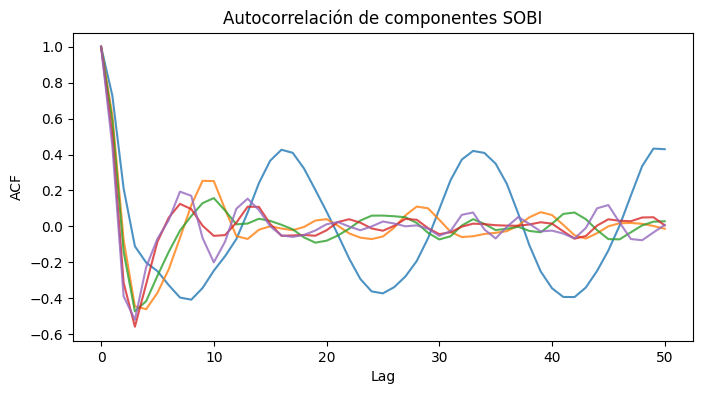

In [ ]:
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import numpy as np

nlags = 50
n_sources = S_est.shape[1]  # columnas = ICs

plt.figure(figsize=(8,4))
for j in range(n_sources):
    acf_j = acf(S_est[:, j], nlags=nlags, fft=True)
    plt.plot(acf_j, alpha=0.8)  # sin label para no petar la leyenda

plt.title("Autocorrelación de componentes SOBI")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()

